# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# Helper functions

def mean_std(dataset):
    """
    Compute average mean and std across dataset to be used with transforms.Normalize
    x -> float32 image tensor 
    """
    mean, std = [], []
    for x,_ in dataset:
        mean.append(x.mean([-2,-1]))
        std.append(x.std([-2,-1]))
    return (torch.tensor(mean, dtype=torch.float32).mean().item(), 
            torch.tensor(std, dtype=torch.float32).mean().item())


def pixel_distribution(image, str='Pixel distribution'):
    """ 
    Plot pixel values
    """
    img_np = np.array(image)
    plt.hist(img_np.ravel(), bins=50, density=True)
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.title(str)

def imshow(image, labels, title=None, normalize=False):
    """plot the firs 10 images from batch, along with the corresponding labels
       if normalze = True , inverting normalization.
    """
    image = np.array(image)
    if normalize:
        mean = np.array([0.1307])
        std = np.array([0.3015])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    fig = plt.figure(figsize=(25, 4))

    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image[idx]), cmap='gray')
        ax.set_title(str(labels[idx].item()))
    

    return ax

In [5]:
#Mean and std to use with transforms.Normalize
# download train data MNIST use transforms.ToTensor() only
# compute mean and std mean_std(train_data)
# update transforms with Normalize((mean), (std)) 
mean, std = mean_std(train_data)
print(mean,std)

-0.00013114688044879586 1.0000141859054565


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
from torch.utils.data import SubsetRandomSampler
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307),(0.3015))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)

#use 10000 datapoints from train_data for validation
idx = list(range(len(train_data)))
np.random.shuffle(idx)
train_idx, val_idx = idx[10000:], idx[:10000]
train_sampler, val_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(val_idx)

#Create train and validation loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=val_sampler)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST('./data', train=False,transform=transform,download=True )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
#data points in test and val loaders
print((len(train_loader.sampler), len(val_loader.sampler)))

(50000, 10000)


In [7]:
images, labels = next(iter(train_loader)) # get batch from train loaders
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


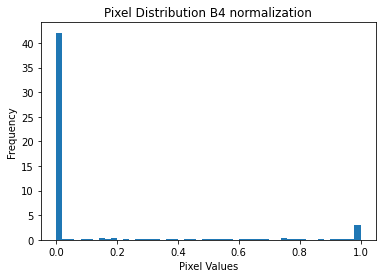

In [8]:
#Inverse Normalization
image = np.array(images[0]) 
mean = np.array([0.1307])
std = np.array([0.3015])
image = std * image + mean
image = np.clip(image, 0, 1)

pixel_distribution(image, 'Pixel Distribution B4 normalization')

(0.20635873079299927, 1.2112230062484741)

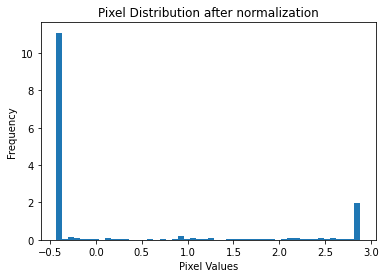

In [9]:
pixel_distribution(images[0],'Pixel Distribution after normalization')
mean_std(zip([images[0]],[None]))# mean is around zero std is 1 

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

Preprocesing steps: 
1. ToTensor() build float32 image tensor from PIL images shape(1,28,28)
2. calculate mean and standard deviation on train_data 
3. add transforms.Normalize((mean), (std)) 
4. using DataLoader class build test and train loaders 
5. visualize batch data -> helper functions 
6. batched shape (64,1,28,28) 
7. I have not flatten data at this moment shape in batch: (64,1,28,28) 
8. flattening tensor in forward pass 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [10]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

<AxesSubplot:title={'center':'6'}>

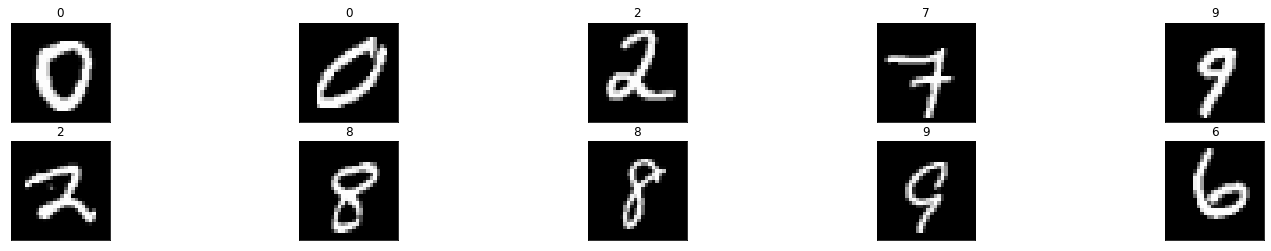

In [11]:
# Explore data
imshow(images,labels,normalize=True)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers:list, dropout_p = 0.2) -> None:
        super().__init__()

        self.input_size=input_size
        self.output_size=output_size
        self.hidden_layers=hidden_layers

        #Create module list and add input to hidden 
        self.modul_list = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        #add hidden layers
        sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.modul_list.extend([nn.Linear(x1,x2) for x1,x2 in sizes])
        #add hidden to output
        self.modul_list.extend([nn.Linear(hidden_layers[-1], output_size)])
        #Dropout
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        #flatten x
        x = x.view(x.shape[0], -1)

        for fc in self.modul_list:
            # run input trought fc layers with ReLU activation and Dropout
            x = self.dropout(F.relu(fc(x)))
        # Return log probabilities 
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
# using L2 Regularization 
net = Model(28*28, 10, [512, 256, 128, 64]) 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
criterion = nn.NLLLoss()# as model returns log probabilities 
net

Model(
  (modul_list): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# params in model
sum([x.numel() for x in net.parameters() if x.requires_grad])

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
# Training model with Early Stoping
best_val_loss = float('inf')
threshold = 0.001 # threshold for min performance improvement
below_treshold, patience = 0, 3

#recording train&val losses after each epoch
train_loss_all, val_loss_all = [], []

epochs = 50
for e in range(epochs):

    train_loss, train_accuracy = 0., 0. # use for epoch
    net.train() # training mode
    #Training loop
    for images, labels in train_loader:
        #check for GPU training
        if not train_on_gpu:
            images, labels, net = images.to('gpu'), labels.to('gpu'), net.to('gpu')

        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        probs = torch.exp(output.detach())# get probabilities
        _,idx = torch.max(probs, dim=1) # get prediction 
        train_accuracy += (idx==labels).type(torch.FloatTensor).mean().item()


    #update variables after training loop
    train_loss = train_loss / len(train_loader)
    train_accuracy = train_accuracy / len(train_loader) # used mean to calculate accuracy
    train_loss_all.append(train_loss)

    
    #Validation loop
    val_loss, val_accuracy = 0., 0.
    net.eval()
    with torch.no_grad():
        for images, labels in val_loader:

            if not train_on_gpu:
                images, labels, net = images.to('cuda'), labels.to('cuda'), net.to('cuda')

            output = net(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            probs = torch.exp(output)
            _,idx = torch.topk(probs, k=1, dim=1)
            equals = idx == labels.view(*idx.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            
    # update variables after validation loop
    val_loss = val_loss / len(val_loader)
    val_accuracy = val_accuracy / len(val_loader)
    val_loss_all.append(val_loss) 


    # print metrics
    print(
            'Epoch: {}/{}... '.format(e+1 , epochs),
            'Training Loss: {:.4}... '.format(train_loss),
            'Validation Loss: {:.4}... '.format(val_loss),
            'Accuracy: {:.4}'.format(val_accuracy)
        )

    #Early Stoping Algorithm and auto saveing
    diff = best_val_loss - val_loss # calculate loss improvement
    #update best loss
    if val_loss < best_val_loss:
        #Saveing model paramiters after each epoch if val loss decreased
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        best_val_loss,
        val_loss))
        print()
        torch.save(net.state_dict(), 'project1.pt')
        best_val_loss=val_loss
    #check treshold
    if diff <= threshold:
        below_treshold +=1
        print('below_treshold: ', below_treshold)
        print()
        #check how many time below trashold and stop if needed
        if below_treshold >= patience:
            print()
            print('Early Stoping Activated......Braking Training Loop......Please check Last Saved Model.......')
            break 


Epoch: 1/50...  Training Loss: 2.242...  Validation Loss: 1.992...  Accuracy: 0.3695
Validation loss decreased (inf --> 1.992042).  Saving model ...

Epoch: 2/50...  Training Loss: 1.793...  Validation Loss: 1.352...  Accuracy: 0.6064
Validation loss decreased (1.992042 --> 1.351807).  Saving model ...

Epoch: 3/50...  Training Loss: 1.36...  Validation Loss: 0.8313...  Accuracy: 0.779
Validation loss decreased (1.351807 --> 0.831272).  Saving model ...

Epoch: 4/50...  Training Loss: 1.119...  Validation Loss: 0.6439...  Accuracy: 0.8148
Validation loss decreased (0.831272 --> 0.643922).  Saving model ...

Epoch: 5/50...  Training Loss: 1.003...  Validation Loss: 0.5598...  Accuracy: 0.8297
Validation loss decreased (0.643922 --> 0.559838).  Saving model ...

Epoch: 6/50...  Training Loss: 0.9326...  Validation Loss: 0.4974...  Accuracy: 0.8404
Validation loss decreased (0.559838 --> 0.497355).  Saving model ...

Epoch: 7/50...  Training Loss: 0.8939...  Validation Loss: 0.4745...  Ac

Plot the training loss (and validation loss/accuracy, if recorded).

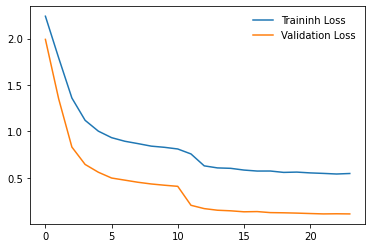

In [13]:
plt.plot(train_loss_all, label='Traininh Loss')
plt.plot(val_loss_all, label='Validation Loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
#Test model
classes = list(range(10))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
test_loss, test_accuracy = 0.,0.

net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        output = net(images)
        test_loss += criterion(output, labels).item()
        probs = torch.exp(output)
        _,preds = torch.max(probs, dim=1)
        correct = preds.eq(labels)
        test_accuracy += correct.sum().item()

        #compute accuracy for each digit
        for i in range(images.size(0)):
            idx = labels[i]
            class_correct[idx] += correct[i].item()
            class_total[idx] += 1

# print metricks
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %s: %d%% -> (%2d/%2d)'% 
        (str(i), 100*class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy: {}......Test Loss: {}'.format(
        round(test_accuracy / len(test_loader.dataset), 3), 
        round(test_loss / len(test_loader), 3)))


Test Accuracy of 0: 99% -> (972/980)
Test Accuracy of 1: 99% -> (1124/1135)
Test Accuracy of 2: 97% -> (1010/1032)
Test Accuracy of 3: 97% -> (984/1010)
Test Accuracy of 4: 96% -> (950/982)
Test Accuracy of 5: 97% -> (870/892)
Test Accuracy of 6: 97% -> (937/958)
Test Accuracy of 7: 96% -> (997/1028)
Test Accuracy of 8: 96% -> (943/974)
Test Accuracy of 9: 95% -> (965/1009)

Test accuracy: 0.975......Test Loss: 0.103


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

I tried different optimizers like Adam, and different learning rate 

## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
#Saveing model
checkpoint = {'input_size':net.input_size,
              'output_size':net.output_size,
              'hidden_layers': [each for each in net.hidden_layers],
              'state_dict' : net.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [16]:
#Load model 
file_path = 'checkpoint.pth'
def load_checkpoint(file_path):
    checkpoint = torch.load(file_path)
    model = Model(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:
net = load_checkpoint(file_path=file_path)

In [ ]:
# to be used with NETRON for visualization
scripted = torch.jit.script(net)
torch.jit.save(scripted, 'mnist_net.pt')